In [39]:
from monai.utils import first, set_determinism
from monai import transforms
from monai.data import Dataset, DataLoader
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import u_net
from monai import inferers
import nibabel as nib
import utils
from icecream import ic

In [40]:
in_dir = Path.cwd()
target_dir = in_dir.parent / 'models'
target_dir.is_dir()

True

In [41]:
train_loss = np.load(target_dir / 'train_loss.npy' )
train_metric = np.load(target_dir / 'train_metric.npy')
test_loss = np.load(target_dir / 'test_loss.npy')
test_metric = np.load(target_dir / 'test_metric.npy')

In [4]:
# Debug
(target_dir / 'train_loss.npy').is_file(),(target_dir / 'train_metric.npy').is_file(), (target_dir / 'test_loss.npy').is_file(), (target_dir / 'test_metric.npy').is_file()


(True, True, True, True)

<Figure size 640x480 with 0 Axes>

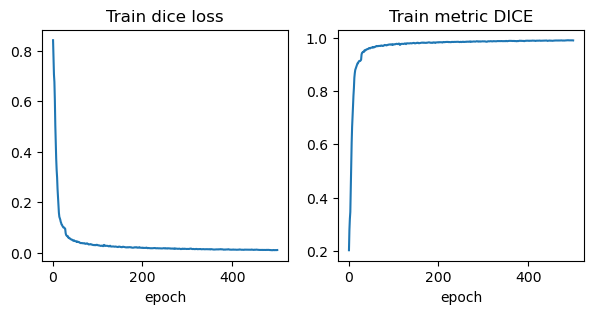

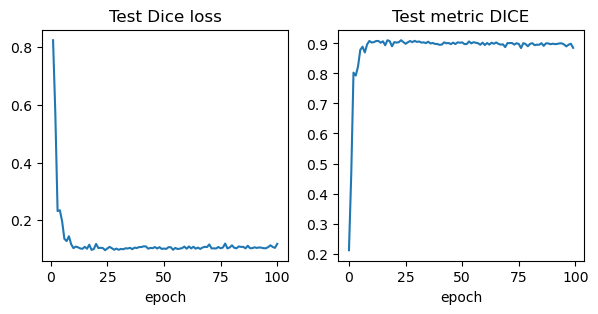

In [53]:
plt.figure(f'Results of {datetime.now().strftime("%d %B")}')
plt.figure(figsize = (7, 3))
plt.subplot(1, 2, 1)
plt.title('Train Dice loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title('Train metric DICE')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.show()

plt.figure(figsize = (7, 3))
plt.subplot(1, 2, 1)
plt.title('Test Dice loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title('Test metric DICE')
x = [i for i in range(len(test_metric))]
y = test_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.show()

In [ ]:
%tensorboard --logdir runs

In [3]:
path_train_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_volumes').glob('*'))
path_train_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'train_segmentations').glob('*'))

path_test_volumes = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_volumes').glob('*'))
path_test_segmentations = sorted(Path(in_dir.parent / 'test_data' / 'nifti_files' / 'test_segmentations').glob('*'))

train_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentations)]
test_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip (path_test_volumes, path_test_segmentations)]

In [4]:
test_transform: transforms = transforms.Compose([
        transforms.LoadImaged(keys = ['vol', 'seg']),
        transforms.EnsureChannelFirstd(keys = ['vol', 'seg']),
        transforms.CropForegroundd(keys = ['vol', 'seg'], source_key = 'vol'),
        transforms.ScaleIntensityRanged(keys = ['vol'], a_min = - 200, a_max = 200, b_min = 0., b_max = 1., clip = True),
        transforms.Spacingd(keys = ['vol', 'seg'], pixdim = (1.5, 1.5, 1.0), mode = ('bilinear', 'nearest')),
        transforms.Orientationd(keys = ['vol', 'seg'], axcodes = 'RAS'),
        transforms.Resized(keys = ['vol', 'seg'], spatial_size = [128, 128, 64], mode = ('bilinear', 'nearest')),    
        transforms.ToTensor()
    ])

c:\Users\graumnitz\AppData\Local\anaconda3\envs\heart\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [5]:
num_workers = os.cpu_count()

test_ds = Dataset(data = test_files,
                  transform = test_transform)
test_dataloader = DataLoader(dataset = test_ds,
                             num_workers = num_workers,
                             batch_size = 1)

In [6]:
model, device = u_net.unet()
model.load_state_dict(torch.load(target_dir / 'ModelV3_diceloss.pth'))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [10]:
test_patient = next(iter(test_dataloader))

In [11]:
torch.unique(test_patient['seg'])

metatensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [18]:
import engine
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.inference_mode():
    t_volume = test_patient['vol'].to(device)
    test_outputs = inferers.sliding_window_inference(inputs = t_volume,
                                                     roi_size = roi_size,
                                                     sw_batch_size = sw_batch_size,
                                                     predictor = model
                                                     )
    prediction = torch.softmax(test_outputs, dim = 1).argmax(dim = 1)
    
    sigmoid_activation = transforms.Activations(sigmoid = True)
    

    

In [19]:
prediction = prediction.unsqueeze(dim = 0)
prediction.shape, test_outputs.shape, test_patient['seg'].shape


(torch.Size([1, 1, 128, 128, 64]),
 torch.Size([1, 8, 128, 128, 64]),
 torch.Size([1, 1, 128, 128, 64]))

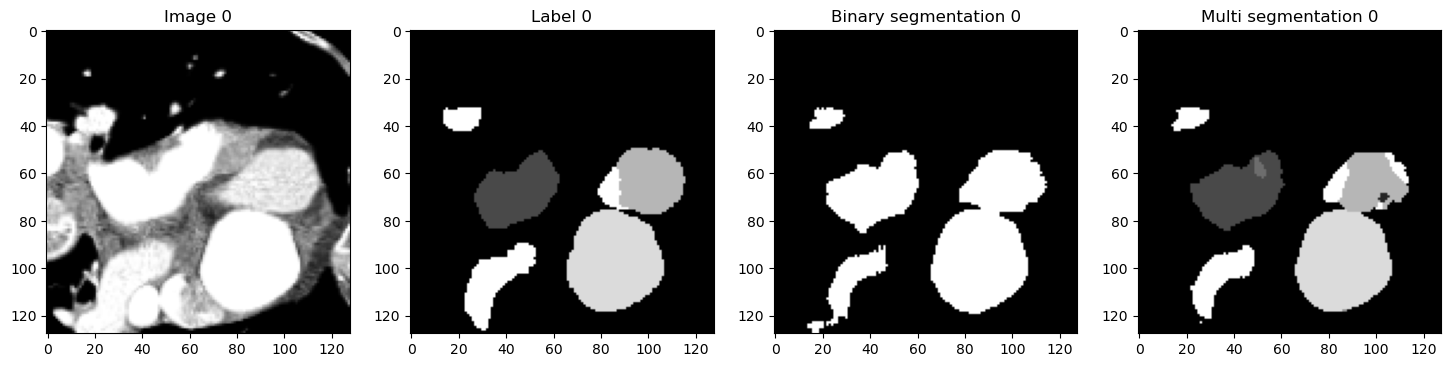

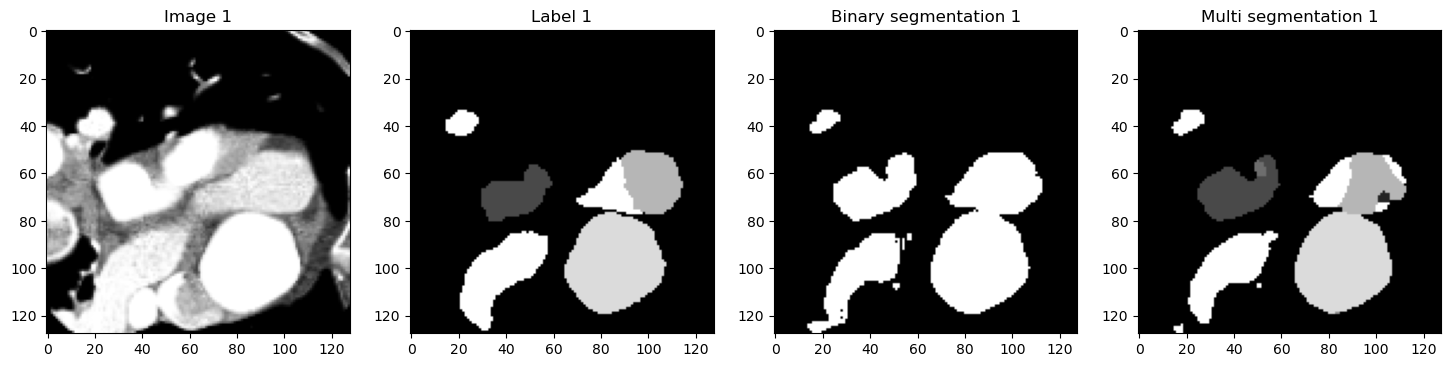

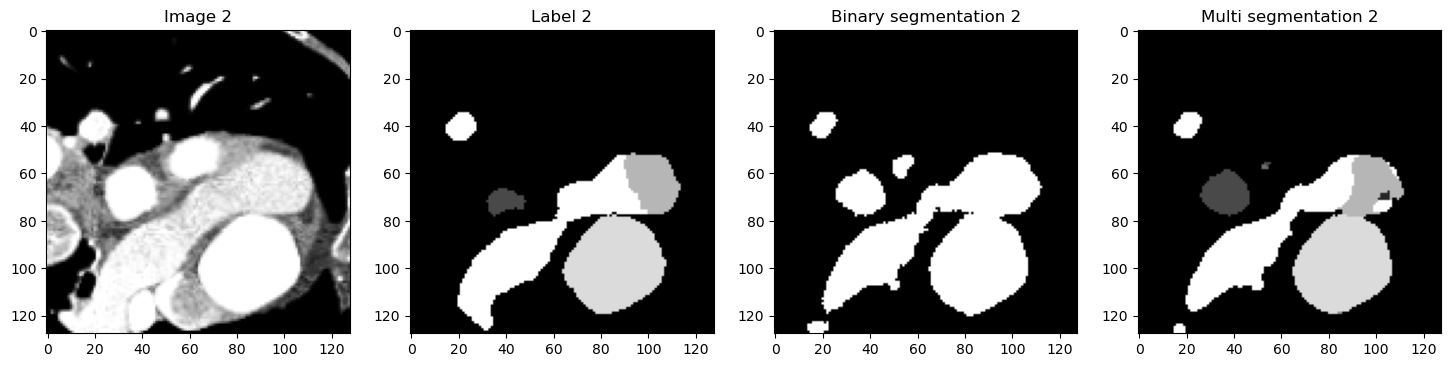

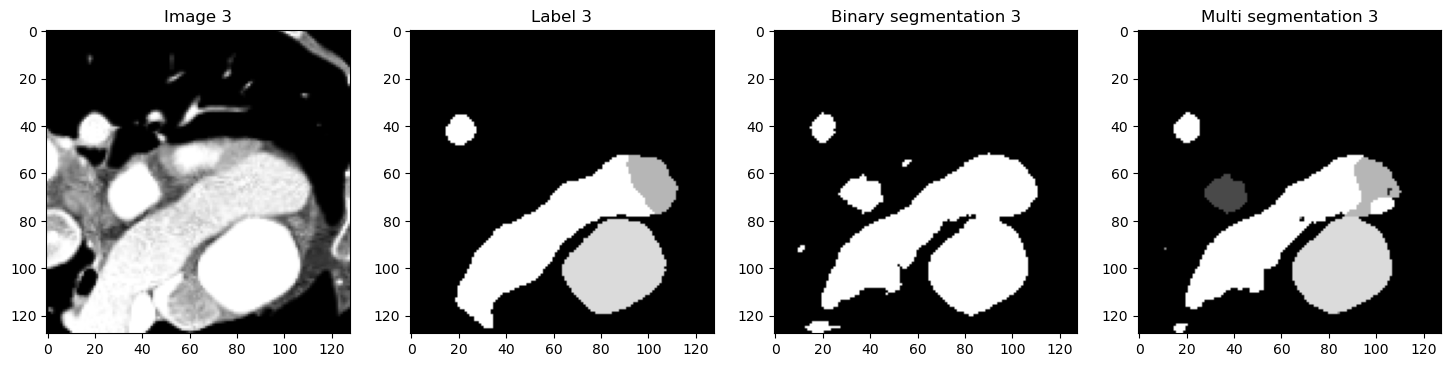

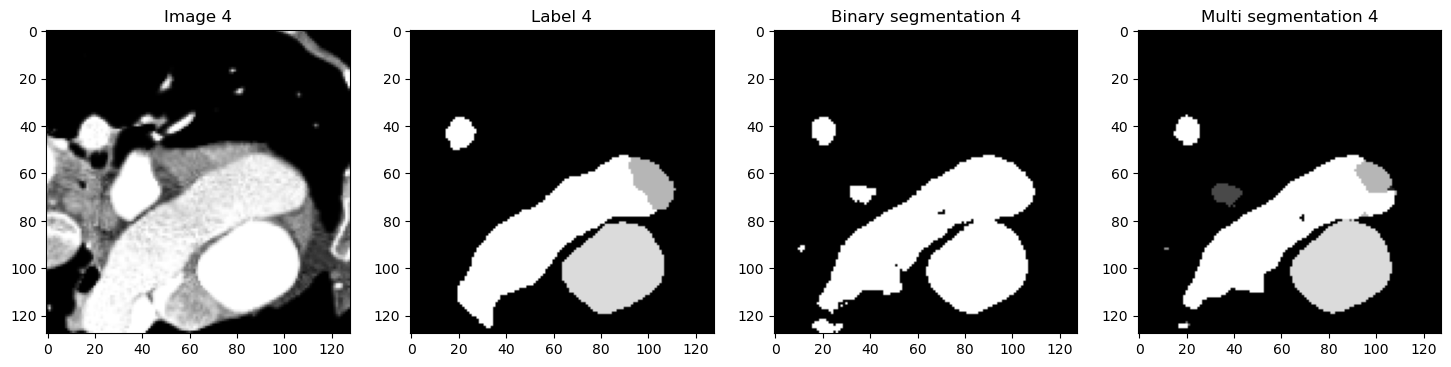

In [20]:
test_outputs = sigmoid_activation(test_outputs)
test_outputs = 1 - test_outputs
test_outputs = test_outputs > 0.53 #Make the Values binary, i think not effective for our cause

z=50
for i in range(5):
        plt.figure('check', (18, 6))
        plt.subplot(1, 4, 1)
        plt.title(f'Image {i}')
        plt.imshow(test_patient['vol'][0, 0, :, :, i+z], cmap = 'gray')
        plt.subplot(1, 4, 2)
        plt.title(f'Label {i}')
        plt.imshow(test_patient['seg'][0, 0, :, :, i+z], cmap ='gray')
        plt.subplot(1, 4, 3)
        plt.title(f'Binary segmentation {i}')
        plt.imshow(test_outputs.detach().cpu()[0, 0, :, :, i + z], cmap = 'gray')
        
        plt.subplot(1, 4, 4)
        plt.title(f'Multi segmentation {i}')
        plt.imshow(prediction.detach().cpu()[0, 0, :, :, i + z], cmap = 'gray')
        plt.show()
        

In [31]:
prediction_list = []
label_list = []
sw_batch_size = 4
roi_size = (128, 128, 64)
model.eval()
with torch.inference_mode():
    for data in test_dataloader:
        t_volume = data['vol']
        test_outputs = inferers.sliding_window_inference(inputs = t_volume,
                                                     roi_size = roi_size,
                                                     sw_batch_size = sw_batch_size,
                                                     predictor = model
                                                     )
        prediction = torch.softmax(test_outputs, dim = 1).argmax(dim = 1)
        prediction_list.append(prediction)
        label_list.append(data['seg'].squeeze(dim = 0))
    

In [8]:
utils.save_nifti(prediction_list = prediction_list,
                  out_dir = Path.cwd().parent)

[INFO] Saving prediction_0 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_1 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_2 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_3 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_4 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_5 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_6 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_7 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_8 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation
[INFO] Saving prediction_9 Nifti file to d:\Meine Ablage\@ Adrian\__heartsegmentation


In [32]:
prediction_cat_tensor = torch.cat(prediction_list)
prediction_cat_tensor.shape
label_cat_tensor = torch.cat(label_list)
ic(label_cat_tensor.shape, prediction_cat_tensor.shape)

ic| label_cat_tensor.shape: torch.Size([10, 128, 128, 64])
    prediction_cat_tensor.shape: torch.Size([10, 128, 128, 64])


(torch.Size([10, 128, 128, 64]), torch.Size([10, 128, 128, 64]))

ic| confmat_tensor: metatensor([[9059676,    9093,   13322,    1259,   13635,    6105,    4420,    9059],
                            [  16586,  237934,     164,   14592,      62,    9483,      93,       4],
                            [  14349,     133,  183569,    2095,      60,       0,     136,       0],
                            [     98,    8672,    1009,  153077,       3,      13,     778,       0],
                            [  18517,      43,      54,       5,  187136,    2438,    2146,      76],
                            [  26985,    5215,       0,     364,    1851,  215219,     498,    3633],
                            [   3808,       4,     182,     938,     265,     214,  122310,     140],
                            [  20517,      50,      26,       0,     265,    4385,    1796,  107201]])


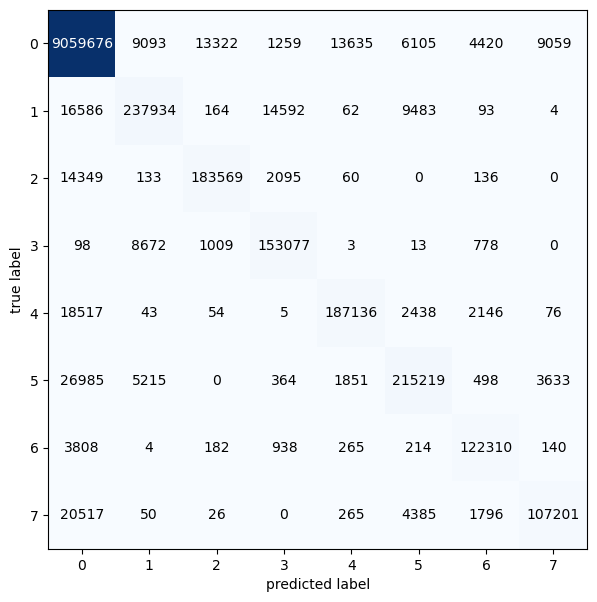

In [37]:
import torchmetrics
from mlxtend import plotting

confmat = torchmetrics.ConfusionMatrix(task = 'multiclass',
                                       num_classes = 8)
confmat_tensor = confmat(preds = prediction_cat_tensor,
                         target = label_cat_tensor)
ic(confmat_tensor)

fig, ax = plotting.plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                         figsize = (10, 7))

In [31]:
target_size = (512, 512, 363)



# Interpolation durchführen
resized_prediction = torch.nn.functional.interpolate(
    prediction.unsqueeze(0).type(torch.float),  # Batch- und Kanal-Dimension hinzufügen
    size=target_size,
    mode='trilinear',  # Dreidimensionale Interpolation
    align_corners=False
)

# Die zusätzlichen Dimensionen wieder entfernen
resized_prediction = resized_prediction.squeeze(0).squeeze(0)

# Überprüfen der Größe
print(resized_prediction.shape)
nib.save(nib.Nifti1Image(resized_prediction.cpu().numpy().astype(float), affine = None), 'test2.nii.gz')

torch.Size([512, 512, 363])


In [27]:
prediction.shape

torch.Size([1, 128, 128, 64])